In [104]:
import wandb
#from wandb import Api
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
HUES = {}
HUES["GCN-Transformer"] = "Red"
HUES["GCN-Avg"] = "Purple"

HUES["GCN-Pretrained"] = "Green"
HUES["GCN-PretrainedT-CurrentDB"] = "Gray"
HUES["GCN-PretrainedT-NoCurrentDB"] = "Green"
HUES["GCN-PreatinedT-NoCurrentDB-NoActualFeats"] = "Black"

In [106]:
api = wandb.Api()

In [153]:
runs = api.runs("pari/LatencyPredictor",
    {"$and": [
      {"config.eval_epoch": 50},
      {"config.traindata_dir": "LatencyCollectorResults/background"},
      #{"config.traindata_dir": "LatencyCollectorResults/new"},
#       {"$or": [
#             {"$and": [
#                 {"tags":"2a"},
#             ]},
#           {
#             "config.config":  "configs/baselines/config_avg.yaml",
#           },
#           {
#             "config.config":  "configs/baselines/config_trans.yaml",
#           },
#       ]} 
    ]
    })

print(f"Found {len(runs)} runs")

Found 72 runs


In [154]:
import time
start = time.time()

dfs = []

cur_run = None
for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(dfs))

took:  0.34416699409484863
64


In [155]:
df = pd.concat(dfs)
print(len(df))

64


In [156]:
def get_alg(row):
    if "avg" in row["config"]:
        return "GCN-Avg"
    elif "trans" in row["config"]:
        return "GCN-Transformer"
    elif "evals" in row["config"]:
        if "all_noimdb_128_col1_fixed.wt" in row["sys_net_pretrained_fn"]:
            #return "GCN-PretrainedT-CurrentDB"
            return "GCN-Pretrained"
        elif row["sys_net_pretrained_fn"] == "models2/noimdb_wk_128.wt":
            #return "GCN-PretrainedT-CurrentDB"
            return "GCN-Pretrained"
        elif row["sys_net_pretrained_fn"] == "models2/noimdb_128_fixed.wt":
            #return "GCN-PreatinedT-NoCurrentDB-NoActualFeats"
            return None
        else:
            return "GCN-Pretrained"
            return None
            #return "GCN-PretrainedT-NoCurrentDB"
        
        #return row["sys_net_pretrained_fn"]
    
def get_workload(row):
    if "stack" in row["tags"]:
        return "Stack"
    elif "tpch" in row["tags"]:
        return "Tpch"
    elif "zdb" in row["tags"]:
        return "zdbs"
    else:
        return "IMDb"
     
df["alg"] = df.apply(lambda x: get_alg(x),axis=1)
df["workload"] = df.apply(lambda x: get_workload(x),axis=1)

In [157]:
df = df[df["alg"].notna()]

In [158]:
print(len(df))
print(set(df["num_instances"]))
print(set(df["seed"]))
print(set(df["config"]))
print(set(df["sys_net_pretrained_fn"]))
print(set(df["alg"]))
print(set(df["tags"]))
print(set(df["workload"]))

64
{1, 2, 3, 4}
{1, 2, 3}
{'configs/baselines/config_avg.yaml', 'configs/evals/config_bg_noimdb4.yaml', 'configs/evals/config_bg_nostack.yaml', 'configs/baselines/config_trans.yaml'}
{'avg', 'models2/bg_stack_attention.wt', 'models2/bg_imdball_attention.wt', None}
{'GCN-Avg', 'GCN-Transformer', 'GCN-Pretrained'}
{'exp2_stack', 'exp1'}
{'IMDb', 'Stack'}


In [159]:
df.keys()

Index(['Tags', 'name', 'lr', 'alg', 'hl1', 'arch', 'seed', 'tags', 'config',
       'col_feat', 'eval_fns', 'num_bins', 'eval_dirs', 'eval_tags',
       'final_act', 'test_size', 'use_wandb', 'eval_epoch', 'normalizer',
       'num_epochs', 'result_dir', 'split_kind', 'sys_net_hl', 'table_feat',
       'wandb_tags', 'max_set_len', 'plan_net_hl', 'actual_feats',
       'global_feats', 'loss_fn_name', 'random_split', 'subplan_ests',
       'sys_net_arch', 'weight_decay', 'y_normalizer', 'num_instances',
       'plan_net_arch', 'skip_timeouts', 'traindata_dir', 'use_eval_tags',
       'log_transform_y', 'num_conv_layers', 'plan_net_dropout',
       'sys_net_log_skip', 'common_batch_size', 'factorized_net_hl',
       'sys_net_num_heads', 'dataset_input_test', 'sys_net_num_layers',
       'sys_net_pretrained', 'dataset_input_train', 'factorized_net_arch',
       'feat_subtree_summary', 'sys_net_save_weights', 'y_normalization_data',
       'feat_undirected_edges', 'plan_net_subplan_ests',
 

IMDb-MSE.pdf
IMDb-Q-Error.pdf
Stack-MSE.pdf
Stack-Q-Error.pdf


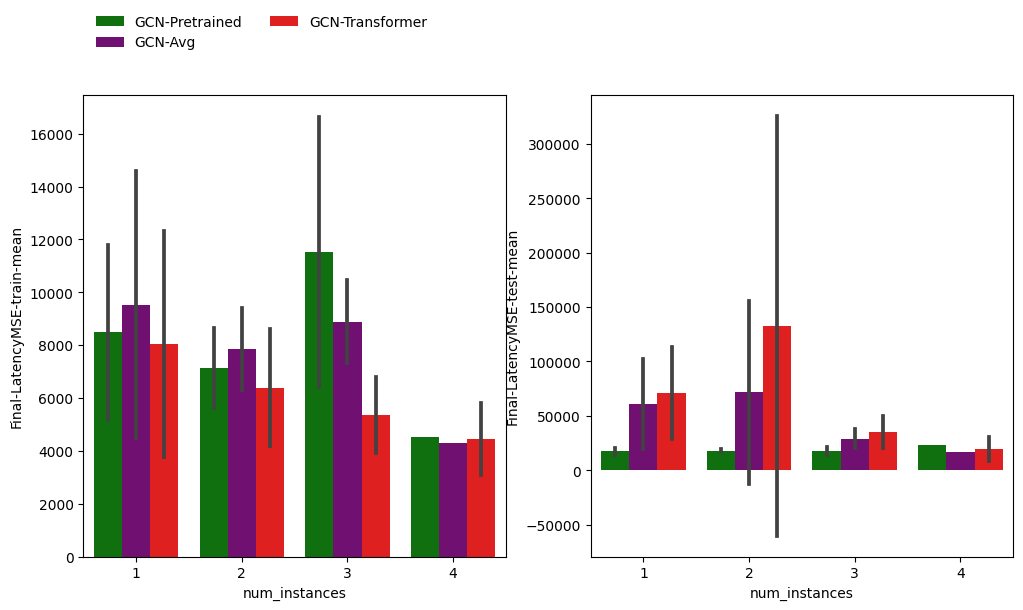

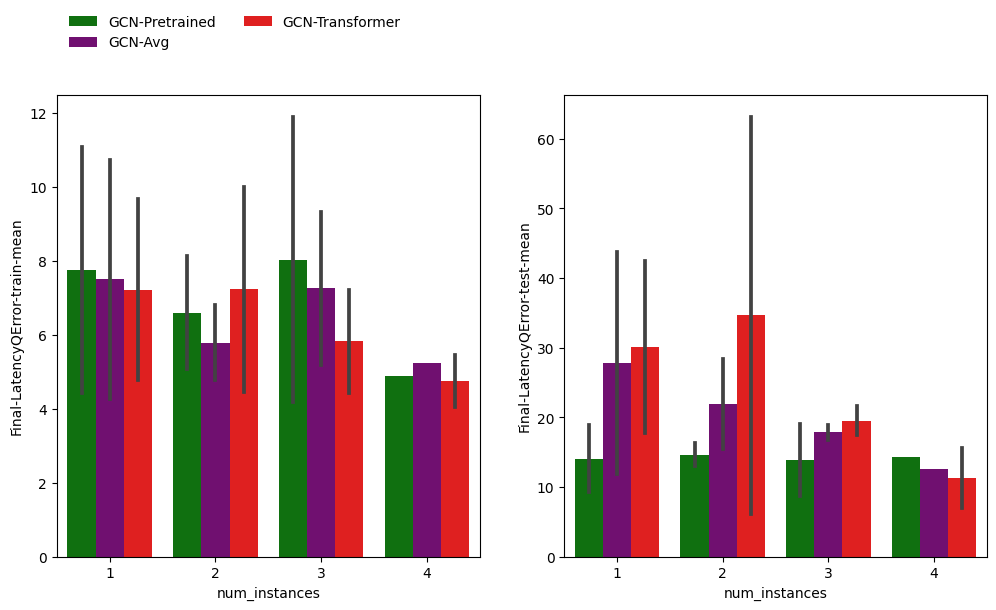

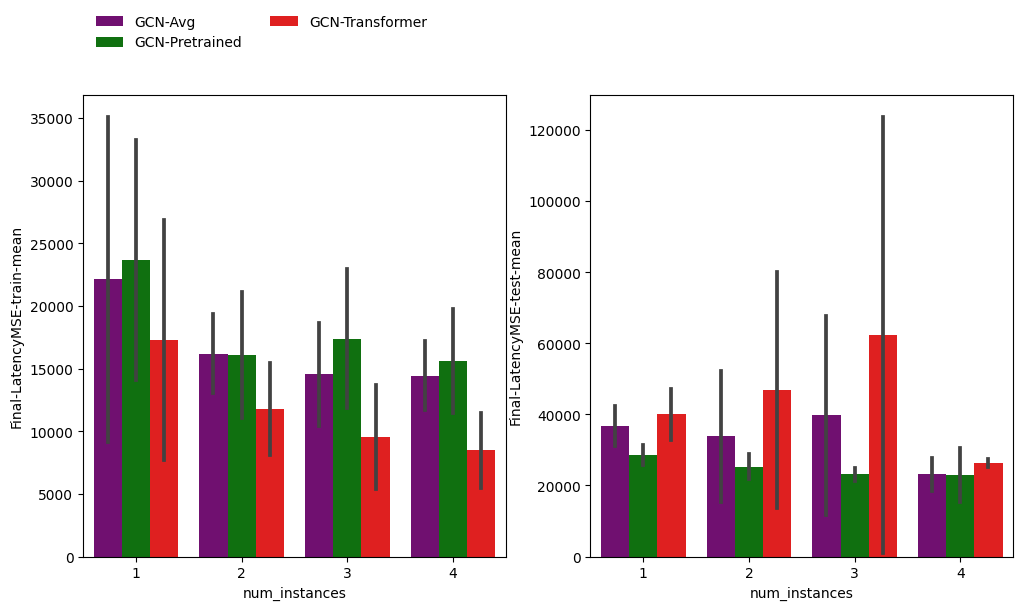

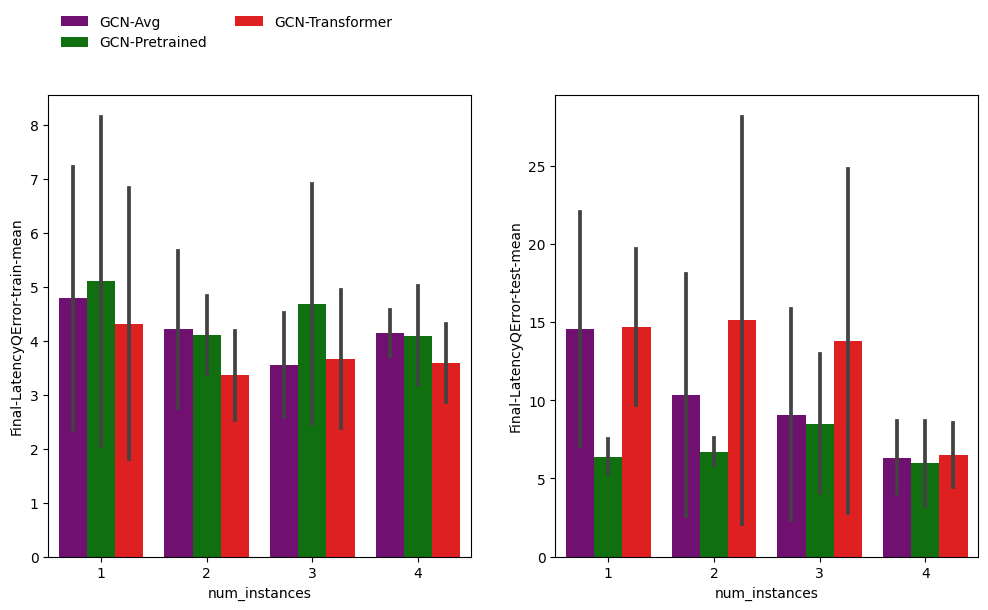

In [160]:
FN_TMP = "{}-{}.pdf"
for wk in set(df["workload"]):
    tmp = df[df["workload"] == wk]
    EB="sd"
    TO_PLOT = ['Final-LatencyMSE-train-mean', 'Final-LatencyMSE-test-mean']
    fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    ## train
    ax = axs[0]
    sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
                ax=ax, errorbar=EB, palette=HUES)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
                       frameon=False)

    sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], 
                errorbar=EB, palette=HUES)
    axs[1].legend().remove()
    
    fn = FN_TMP.format(wk, "MSE")
    print(fn)
    plt.savefig(fn, bbox_inches="tight")
    
    TO_PLOT = ['Final-LatencyQError-train-mean', 'Final-LatencyQError-test-mean']
    fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
    ## train
    sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
               palette=HUES)
    #axs[0].legend().remove()
    legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
               frameon=False)
    
    sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], errorbar=EB,
               palette=HUES)
    axs[1].legend().remove()
    
    fn = FN_TMP.format(wk, "Q-Error")
    print(fn)
    plt.savefig(fn, bbox_inches="tight")

Test-IMDb-MSE.pdf
Test-IMDb-Q-Error.pdf
Test-Stack-MSE.pdf
Test-Stack-Q-Error.pdf


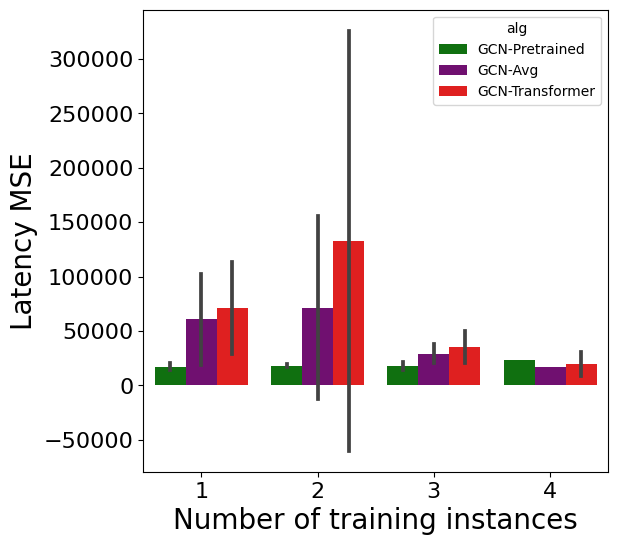

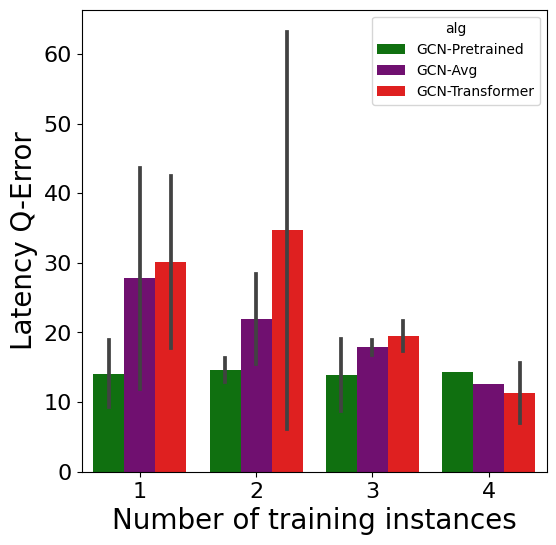

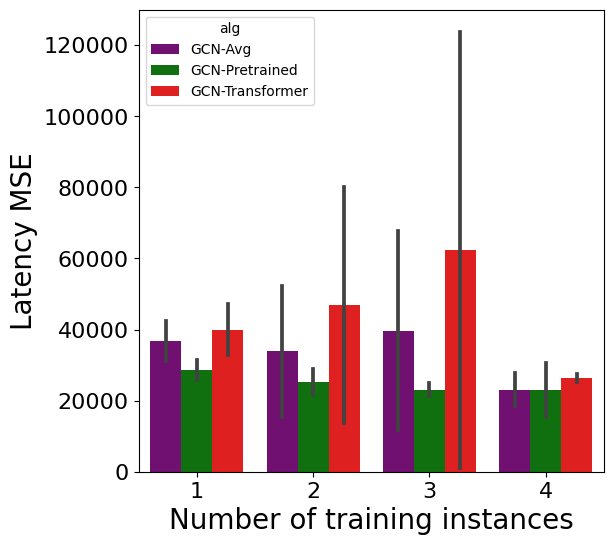

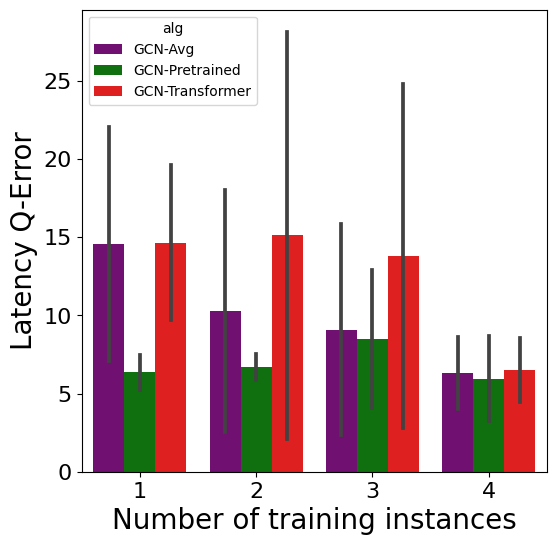

In [162]:
FN_TMP = "Test-{}-{}.pdf"
for wk in set(df["workload"]):
    tmp = df[df["workload"] == wk]
    EB="sd"
    TO_PLOT = ['Final-LatencyMSE-train-mean', 'Final-LatencyMSE-test-mean']
    fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

    ## train
#     ax = axs[0]
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
#                 ax=ax, errorbar=EB, palette=HUES)
#     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                        frameon=False)
    
    ax = axs
    sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=ax, 
                errorbar=EB, palette=HUES)
    #axs[1].legend().remove()
    ax.set_xlabel("Number of training instances", fontsize=20)
    ax.set_ylabel("Latency MSE", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    fn = FN_TMP.format(wk, "MSE")
    print(fn)
    plt.savefig(fn, bbox_inches="tight")
    
    TO_PLOT = ['Final-LatencyQError-train-mean', 'Final-LatencyQError-test-mean']
    fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    
    ## train
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
#                palette=HUES)
    #axs[0].legend().remove()
#     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                frameon=False)
    
    ax = axs
    sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs, errorbar=EB,
               palette=HUES)
    ax.set_xlabel("Number of training instances", fontsize=20)
    ax.set_ylabel("Latency Q-Error", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    #axs[1].legend().remove()
    
    fn = FN_TMP.format(wk, "Q-Error")
    print(fn)
    plt.savefig(fn, bbox_inches="tight")